<a href="https://colab.research.google.com/github/bilgeyucel/presentations/blob/main/berlin-buzzwords-2024/extract_structured_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Structured Output from Unstructured Text

A notebook to generate a JSON from an unstructed text using [Haystack](https://github.com/deepset-ai/haystack), the open source LLM framework.

by Bilge Yucel [Twitter](https://twitter.com/bilgeycl), [Linkedin](https://www.linkedin.com/in/bilge-yucel/)


📚 Useful Resources
* [Documentation](https://docs.haystack.deepset.ai/docs?utm_campaign=developer-relations&utm_source=bbuzz&utm_medium=colab)
* [Website](https://haystack.deepset.ai?utm_campaign=developer-relations&utm_source=bbuzzy&utm_medium=colab)

## Preparing the Colab Environment

Enable the debug mode of logging:

In [1]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack.pipeline.pipeline").setLevel(logging.DEBUG)

## Installing Dependencies
Install Haystack, cohere-haystack (optional) and [colorama](https://pypi.org/project/colorama/) with pip:

In [2]:
%%bash

pip install haystack-ai
pip install colorama
pip install cohere-haystack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.2/345.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: tokenize

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.41.2 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.15.2 which is incompatible.


## Defining a Schema to Parse the JSON Object

Define a simple JSON schema for the data you want to extract from a text passsage using the LLM. As the first step, define two [Pydantic models](https://docs.pydantic.dev/1.10/usage/models/), `City` and `CitiesData`, with suitable fields and types.

In [3]:
from typing import List, Optional
from pydantic import BaseModel


class City(BaseModel):
    name: str
    country: str
    population: int
    landmarks: Optional[List[str]]


class CitiesData(BaseModel):
    cities: List[City]

In [4]:
CitiesData.model_json_schema(mode='serialization')

{'$defs': {'City': {'properties': {'name': {'title': 'Name', 'type': 'string'},
    'country': {'title': 'Country', 'type': 'string'},
    'population': {'title': 'Population', 'type': 'integer'},
    'landmarks': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'},
      {'type': 'null'}],
     'title': 'Landmarks'}},
   'required': ['name', 'country', 'population', 'landmarks'],
   'title': 'City',
   'type': 'object'}},
 'properties': {'cities': {'items': {'$ref': '#/$defs/City'},
   'title': 'Cities',
   'type': 'array'}},
 'required': ['cities'],
 'title': 'CitiesData',
 'type': 'object'}

> You can change these models according to the format you wish to extract from the text.

Then, generate a JSON schema from Pydantic models using `model_json_schema()` and convert it to a json string with `json.dumps()`. You will later on use this schema in the prompt to instruct the LLM.

To learn more about the JSON schemas, visit [Pydantic Schema](https://docs.pydantic.dev/latest/concepts/json_schema/).  

In [5]:
import json

json_schema = json.dumps(CitiesData.model_json_schema(mode='serialization'), indent=2)

In [6]:
json_schema

'{\n  "$defs": {\n    "City": {\n      "properties": {\n        "name": {\n          "title": "Name",\n          "type": "string"\n        },\n        "country": {\n          "title": "Country",\n          "type": "string"\n        },\n        "population": {\n          "title": "Population",\n          "type": "integer"\n        },\n        "landmarks": {\n          "anyOf": [\n            {\n              "items": {\n                "type": "string"\n              },\n              "type": "array"\n            },\n            {\n              "type": "null"\n            }\n          ],\n          "title": "Landmarks"\n        }\n      },\n      "required": [\n        "name",\n        "country",\n        "population",\n        "landmarks"\n      ],\n      "title": "City",\n      "type": "object"\n    }\n  },\n  "properties": {\n    "cities": {\n      "items": {\n        "$ref": "#/$defs/City"\n      },\n      "title": "Cities",\n      "type": "array"\n    }\n  },\n  "required": [\n   

## Creating a Custom Component: OutputValidator

`OutputValidator` is a custom component that validates if the JSON object the LLM generates complies with the provided [Pydantic model](https://docs.pydantic.dev/1.10/usage/models/). If it doesn't, OutputValidator returns an error message along with the incorrect JSON object to get it fixed in the next loop.

For more details about custom components, see [Creating Custom Components](https://docs.haystack.deepset.ai/v2.0/docs/custom-components).

In [100]:
import json
import random
import pydantic
from pydantic import ValidationError
from typing import Optional, List
from colorama import Fore
from haystack import component

# Define the component input parameters
@component
class OutputValidator:
    def __init__(self, pydantic_model: pydantic.BaseModel):
        self.pydantic_model = pydantic_model

    # Define the component output
    @component.output_types(valid_replies=List[str], invalid_replies=Optional[List[str]], error_message=Optional[str])
    def run(self, replies: List[str]):

        print(
                Fore.BLUE
                + replies[0]
            )
        ## Try to parse the LLM's reply ##
        # If the LLM's reply is a valid JSON, continue
        try:
            output_dict = json.loads(replies[0])
        except:
            print(
                Fore.RED
                + f"Invalid JSON from LLM - Let's try again.\n"
                f"Error from OutputValidator: Not a valid JSON"
            )
            return {"invalid_replies": replies[0], "error_message": "Not a valid JSON"}

        # If the LLM's reply complies with the Pydantic model, return "valid_replies"
        try:
            self.pydantic_model.parse_obj(output_dict)
            print(
                Fore.GREEN
                + f"Valid JSON from LLM - No need for looping: {replies[0]}"
            )
            return {"valid_replies": replies[0]}

        # If the LLM's reply is corrupted or not valid, return "invalid_replies" and the "error_message" for LLM to try again
        except (ValueError, ValidationError) as e:
            print(
                Fore.RED
                + f"Invalid JSON from LLM - Let's try again.\n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies[0], "error_message": str(e)}

Then, create an OutputValidator instance with `CitiesData` that you have created before.

## Creating the Prompt

Write instructions for the LLM for converting a passage into a JSON format. Ensure the instructions explain how to identify and correct errors if the JSON doesn't match the required schema. Once you create the prompt, initialize PromptBuilder to use it.  

For information about Jinja2 template and PromptBuilder, see [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder).

In [128]:
from haystack.components.builders import PromptBuilder

prompt_template = """
Create a JSON object from the information present in this passage: {{passage}}.
Only use information that is present in the passage. Follow this Pydantic JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}
Make sure your response is a dict and not a list.
{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the JSON format above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected JSON without any extra text. Just use the information given in the text.
{% endif %}
"""

## Initalizing the Generator

[OpenAIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/openaigenerator) generates
text using OpenAI's `gpt-3.5-turbo` model by default. Set the `OPENAI_API_KEY` variable and provide a model name to the Generator.

In [34]:
import os
from google.colab import userdata

from haystack.components.generators import OpenAIGenerator, HuggingFaceAPIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = userdata.get('HF_API_TOKEN')
if "COHERE_API_KEY" not in os.environ:
    os.environ["COHERE_API_KEY"] = userdata.get('COHERE_API_KEY')


In [145]:
generator = OpenAIGenerator()

generator = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-7B-Instruct-v0.2"})
# mistralai/Mistral-7B-v0.3
# mistralai/Mistral-7B-Instruct-v0.1
# mistralai/Mistral-7B-Instruct-v0.3
# meta-llama/Llama-2-7b-chat-hf
# HuggingFaceH4/zephyr-7b-beta
# meta-llama/Meta-Llama-3-8B-Instruct

In [149]:
from haystack_integrations.components.generators.cohere import CohereGenerator

generator = CohereGenerator(model="c4ai-aya-23") #command-r c4ai-aya-23

## Building the Pipeline

Add all components to your pipeline and connect them. Add connections from `output_validator` back to the `prompt_builder` for cases where the produced JSON doesn't comply with the JSON schema. Set `max_loops_allowed` to avoid infinite looping.

In [150]:
from haystack import Pipeline

pipeline = Pipeline(max_loops_allowed=5)

# Add components to your pipeline
pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")
pipeline.add_component(instance=generator, name="llm")
pipeline.add_component(instance=OutputValidator(pydantic_model=CitiesData), name="output_validator")

# Now, connect the components to each other
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")

# If a component has more than one output or input, explicitly specify the connections:
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: CohereGenerator
  - output_validator: OutputValidator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])

## Testing the Pipeline

Run the pipeline with an example passage that you want to convert into a JSON format and the `json_schema` you have created for `CitiesData`.

The output of the LLM should be compliant with the `json_schema`. If the LLM doesn't generate the correct JSON object, it will loop back and try again.

In [71]:
## Basic passage
passage = "Berlin is the capital of Germany. It has a population of 3,850,809. Paris, France's capital, has 2.161 million residents. Lisbon is the capital and the largest city of Portugal with the population of 504,718."

In [83]:
## Passage with more information (landmarks)
passage= """
Berlin, the vibrant and historic capital of Germany, is a metropolis teeming with a population of approximately 3,850,809 residents. This city is a fascinating blend of contemporary culture, rich history, and innovative architecture, standing as a testament to Germany's resilience and progress. Berlin is known for its iconic landmarks, such as the Brandenburg Gate, the Berlin Wall Memorial, and the Reichstag building, all of which attract millions of tourists each year.

In contrast, Paris, the enchanting capital of France, is home to around 2.161 million people. Renowned as the "City of Light," Paris is celebrated for its timeless charm, exquisite art, and world-renowned cuisine. The city boasts a myriad of famous attractions, including the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral, each contributing to its status as one of the most visited cities in the world.

Lisbon, the picturesque capital and the largest city of Portugal, has a population of 504,718. Perched on the edge of the Atlantic Ocean, Lisbon is known for its unique blend of traditional heritage and modernism. The city's vibrant neighborhoods, such as Alfama and Bairro Alto, its historic trams, and the stunning views from São Jorge Castle, all add to its allure. Lisbon's rich maritime history and cultural significance make it a fascinating destination for travelers from around the globe.

Istanbul, straddling Europe and Asia across the Bosphorus Strait, is Turkey's most populous city, with a staggering population of over 15 million residents. As the historic heart of the Ottoman Empire, Istanbul is a city of contrasts, where ancient mosques and bustling bazaars coexist with modern skyscrapers and cosmopolitan nightlife. Key landmarks such as the Hagia Sophia, the Blue Mosque, and Topkapi Palace reflect its rich historical and cultural heritage, making it an enthralling destination for visitors.

London, the bustling capital of the United Kingdom, boasts a diverse population of approximately 8.982 million people. A global city renowned for its influence on finance, culture, and politics, London is a hub of activity and innovation. The city's landscape is dotted with iconic sites, including the Tower of London, Buckingham Palace, the Houses of Parliament, and the British Museum. London's vibrant arts scene, historical significance, and cultural diversity ensure its status as one of the world's most dynamic and captivating cities.
"""

In [151]:
## Passage without full information (London has no landmarks)
passage= """
Berlin, the vibrant and historic capital of Germany, is a metropolis teeming with a population of approximately 3,850,809 residents. This city is a fascinating blend of contemporary culture, rich history, and innovative architecture, standing as a testament to Germany's resilience and progress. Berlin is known for its iconic landmarks, such as the Brandenburg Gate, the Berlin Wall Memorial, and the Reichstag building, all of which attract millions of tourists each year.

In contrast, Paris, the enchanting capital of France, is home to around 2.161 million people. Renowned as the "City of Light," Paris is celebrated for its timeless charm, exquisite art, and world-renowned cuisine. The city boasts a myriad of famous attractions, including the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral, each contributing to its status as one of the most visited cities in the world.

Lisbon, the picturesque capital and the largest city of Portugal, has a population of 504,718. Perched on the edge of the Atlantic Ocean, Lisbon is known for its unique blend of traditional heritage and modernism. The city's vibrant neighborhoods, such as Alfama and Bairro Alto, its historic trams, and the stunning views from São Jorge Castle, all add to its allure. Lisbon's rich maritime history and cultural significance make it a fascinating destination for travelers from around the globe.

Istanbul, straddling Europe and Asia across the Bosphorus Strait, is Turkey's most populous city, with a staggering population of over 15 million residents. As the historic heart of the Ottoman Empire, Istanbul is a city of contrasts, where ancient mosques and bustling bazaars coexist with modern skyscrapers and cosmopolitan nightlife. Key landmarks such as the Hagia Sophia, the Blue Mosque, and Topkapi Palace reflect its rich historical and cultural heritage, making it an enthralling destination for visitors.

London, the bustling capital of the United Kingdom, boasts a diverse population of approximately 8.982 million people.
"""

In [67]:
## Long passage

passage = """
### A Journey Through Capitals

It was the trip of a lifetime, a whirlwind journey through five of the world's most captivating capital cities. Sofia, a travel blogger with a thirst for adventure and an eye for detail, had always dreamt of such an odyssey. With her notebook and camera in tow, she set out to explore the world.

Sofia's first stop was Tokyo, a city that thrummed with energy. Stepping out of the airport, she was immediately engulfed in the vibrant chaos of a metropolis that never slept. The city, home to exactly 13,515,271 people, felt alive with possibility. Her first destination was the iconic Tokyo Tower, a red and white sentinel against the skyline. She marveled at the view from the top, the city sprawled out beneath her like a living, breathing entity.

From there, she made her way to the serene grounds of the Sensoji Temple. The contrast was striking: from the ultramodern skyscrapers to a haven of tranquility that had stood for centuries. The temple's incense-laden air and the gentle hum of prayers offered a moment of peace amidst the bustling city.

Her days in Tokyo were filled with exploration. In Shibuya, she navigated the famous crossing, swept along by the tide of humanity. In Shinjuku, she wandered through neon-lit streets, discovering cutting-edge technology stores and the latest in fashion. Tokyo was a city of contrasts, a place where tradition and innovation danced together in perfect harmony.

Next, Sofia flew to Paris, often called "The City of Light." With 2,161,000 resident here, Paris felt both intimate and grand. She began her adventure with a visit to the Eiffel Tower, the iron lady who stood tall against the blue Parisian sky. As she ascended, the city's charm unfolded beneath her, a tapestry of history and elegance.

The Louvre was her next stop, where she spent hours lost among masterpieces. The Mona Lisa's enigmatic smile held her captive, and she found herself entranced by the vast collection of art that spanned millennia. Notre-Dame Cathedral, with its Gothic spires and haunting beauty, filled her with awe. Walking through its grand nave, she felt the weight of centuries of history.

But it was the streets of Paris that truly captured her heart. She spent afternoons in quaint cafes, sipping coffee and indulging in flaky croissants. The Seine's gentle flow mirrored the rhythm of the city, and as she strolled along its banks, she understood why Paris was synonymous with romance.

From Europe, Sofia crossed the Atlantic to Washington, D.C., the political heart of the United States. With a population of more than 692k, the city felt powerful yet accessible. Her first stop was the White House, an enduring symbol of democracy. Standing before it, she couldn't help but reflect on the history made within its walls.

The Capitol Building, with its majestic dome, was next. As she walked its halls, she felt the gravity of the decisions that had shaped a nation. The Lincoln Memorial, reflecting in the pool, was a poignant reminder of the country's journey and the leaders who had guided it.

Washington, D.C. was also a city of museums. Sofia spent hours in the Smithsonian Institution, each exhibit opening a window to a different world. The cherry blossom trees, in full bloom, added a touch of delicate beauty to the city's grandeur. Walking beneath their pink canopy, she felt a deep connection to the spirit of the place.

Her journey then took her to the southern hemisphere, to Canberra, Australia. With a population of 431,380, Canberra was a city of meticulous design and natural beauty. Sofia began her exploration at the Australian War Memorial, a solemn tribute to the nation's heroes. The stories of bravery and sacrifice moved her deeply.

The National Gallery of Australia was a treasure trove of art, where she marveled at both indigenous and contemporary works. The Parliament House, with its sweeping architecture, stood as a testament to Australia's democratic spirit. She wandered through its halls, gaining insight into the country's political landscape.

Canberra's green spaces provided a perfect balance to its cultural landmarks. Sofia spent her afternoons hiking through nature reserves and enjoying the city's outdoor activities. The blend of history and nature in Canberra offered a serene yet stimulating experience.

The final leg of Sofia's journey brought her to Ottawa, Canada. The city's rich cultural heritage and political significance were immediately evident. Parliament Hill, with its Gothic Revival architecture, dominated the skyline. Sofia watched the Changing of the Guard ceremony, feeling a sense of national pride and tradition.

The National Gallery of Canada housed an impressive collection of art, and Sofia found herself particularly drawn to the works of Canadian artists. The Rideau Canal, winding through the city, was a focal point of her visit. In winter, it transformed into the world's largest skating rink, and though it wasn't frozen during her visit, she could imagine the joy it brought to residents and visitors alike.

Ottawa's festivals and vibrant arts scene provided a lively backdrop to her days. She attended music performances and art exhibitions, immersing herself in the city's diverse culture. Each festival was a celebration of creativity, reflecting the dynamic spirit of the city. There must have been a reason why 1.017 million people live here.

As Sofia's journey came to an end, she reflected on the myriad experiences each city had offered. Tokyo's blend of tradition and modernity, Paris's romantic charm, Washington, D.C.'s historical significance, Canberra's natural beauty, and Ottawa's cultural vibrancy had each left an indelible mark on her.

Through her travels, she had seen the world not just through landmarks and attractions, but through the stories of the people and the spirit of each place. It was a journey of discovery and connection, one that she would carry with her for the rest of her life.
"""

In [152]:
result = pipeline.run({"prompt_builder": {"passage": passage, "schema": json_schema}})

{
    "cities": [
        {
            "name": "Berlin",
            "country": "Germany",
            "population": 3850809,
            "landmarks": [
                "Brandenburg Gate",
                "Berlin Wall Memorial",
                "Reichstag Building"
            ]
        },
        {
            "name": "Paris",
            "country": "France",
            "population": 2161000,
            "landmarks": [
                "Eiffel Tower",
                "Louvre Museum",
                "Notre-Dame Cathedral"
            ]
        },
        {
            "name": "Lisbon",
            "country": "Portugal",
            "population": 504718,
            "landmarks": [
                "Alfama",
                "Bairro Alto",
                "São Jorge Castle"
            ]
        },
        {
            "name": "Istanbul",
            "country": "Turkey",
            "population": 15000000,
            "landmarks": [
                "Hagia Sophia",
                "Blue 

> If you encounter `PipelineMaxLoops: Maximum loops count (5) exceeded for component 'prompt_builder'.` error, consider increasing the maximum loop count or simply rerun the pipeline.

### Visualize the Pipeline


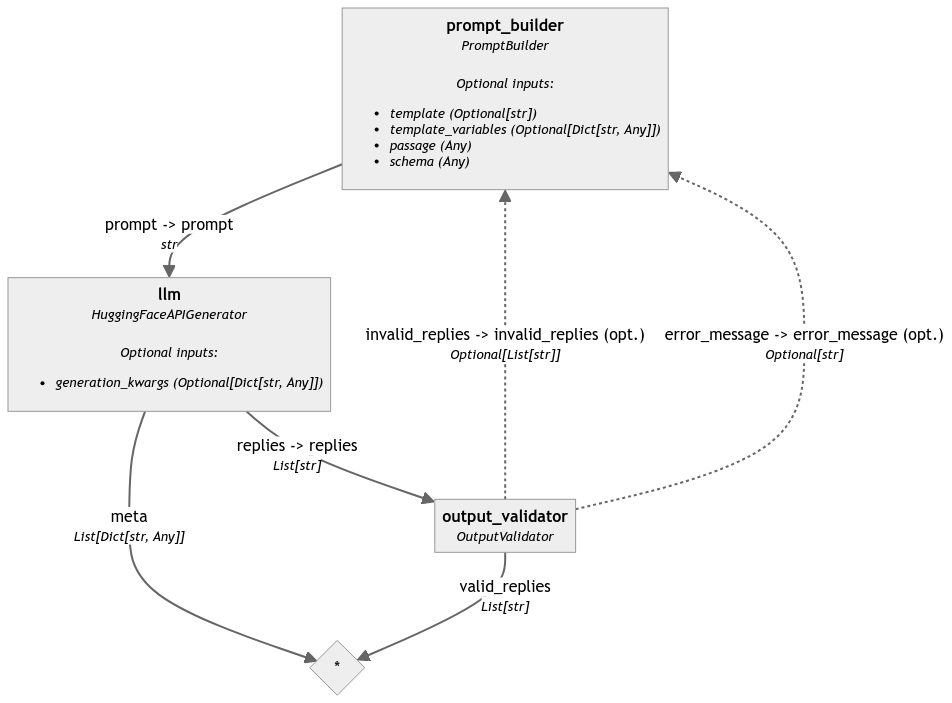

In [ ]:
pipeline.show()

### Print the Correct JSON
If you didn't get any error, you can now print the corrected JSON.

In [ ]:
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

## Bonus: Check Verify the Content in JSON

In [138]:
prompt_template_validator = """
You'll have a JSON and a text, detect if each information in this JSON object can be extracted from the text.
If some information in JSON is not mentioned in the text, say "NO". Otherwise, say "YES".

JSON object: {{json_object}}
text: {{text}}
"""

In [141]:
from haystack import Pipeline

pipeline = Pipeline(max_loops_allowed=10)

# Add components to your pipeline
pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")
pipeline.add_component(instance=HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-7B-Instruct-v0.3"}), name="llm")
pipeline.add_component(instance=OutputValidator(pydantic_model=CitiesData), name="output_validator")
pipeline.add_component(instance=PromptBuilder(template=prompt_template_validator), name="prompt_template_validator")
pipeline.add_component(instance=OpenAIGenerator(), name="generator_validator")


# Now, connect the components to each other
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")

# If a component has more than one output or input, explicitly specify the connections:
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

pipeline.connect("output_validator.valid_replies", "prompt_template_validator.json_object")
pipeline.connect("prompt_template_validator", "generator_validator")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
  - output_validator: OutputValidator
  - prompt_template_validator: PromptBuilder
  - generator_validator: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])
  - output_validator.valid_replies -> prompt_template_validator.json_object (List[str])
  - prompt_template_validator.prompt -> generator_validator.prompt (str)

In [142]:
result = pipeline.run({"prompt_builder": {"passage": passage, "schema": json_schema}, "prompt_template_validator":{"text": passage}}, include_outputs_from={"output_validator", "prompt_template_validator"})


{
    "cities": [
        {
            "name": "Berlin",
            "country": "Germany",
            "population": 3850809,
            "landmarks": ["Brandenburg Gate", "Berlin Wall Memorial", "Reichstag building"]
        },
        {
            "name": "Paris",
            "country": "France",
            "population": 2161000,
            "landmarks": ["Eiffel Tower", "Louvre Museum", "Notre-Dame Cathedral"]
        },
        {
            "name": "Lisbon",
            "country": "Portugal",
            "population": 504718,
            "landmarks": []
        },
        {
            "name": "Istanbul",
            "country": "Turkey",
            "population": 15000000,
            "landmarks": ["Hagia Sophia", "Blue Mosque", "Topkapi Palace"]
        },
        {
            "name": "London",
            "country": "United Kingdom",
            "population": 8982000,
            "landmarks": []
        }
    ]
}
Valid JSON from LLM - No need for looping: 
{
    "cities": [

In [143]:
result["generator_validator"]["replies"]

['YES, YES, YES, YES\nNO']

In [120]:
result

{'llm': {'meta': [{'model': 'mistralai/Mistral-7B-Instruct-v0.1',
    'finish_reason': None,
    'usage': {'completion_tokens': 0}}]},
 'generator_validator': {'replies': ['Based on the text provided, the following information from the JSON object can be extracted:\n\n1. Berlin:\n- Population: 3,850,809\n- Landmarks: Brandenburg Gate, Berlin Wall Memorial, Reichstag building\n\n2. Paris:\n- Population: 2,161,000\n- Landmarks: Eiffel Tower, Louvre Museum, Notre-Dame Cathedral\n\n3. Lisbon:\n- Population: 504,718\n- Landmarks: Alfama, Bairro Alto, São Jorge Castle\n\n4. Istanbul:\n- Population: 15,000,000\n- Landmarks: Hagia Sophia, Blue Mosque, Topkapi Palace\n\n5. London:\n- Population: 8,982,000\n\nOverall, the text provides accurate information for all cities regarding population and major landmarks.'],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 166,
     'prompt_tokens': 737,
     'total_tokens': 903}}]}